In [2]:
from sklearn.datasets import make_regression
import numpy as np
import  matplotlib.pyplot as plt
from scipy.stats import norm

In [3]:
# Generate synthetic dataset with 1000 samples and 10 features
X, y = make_regression(n_samples=1000, n_features=10, noise=0.1)

# Add Gaussian noise to target variable
y += np.random.normal(0, 1, size=y.shape)

In [4]:
# Assume the observed data follows a normal distribution with mean mu and standard deviation sigma
mu = 0
sigma = 1

# Generate some sample data
data = X

# Compute the log-likelihood of the data under the assumed normal distribution
log_likelihood = np.sum(norm.logpdf(data, mu, sigma))

print("Log-likelihood of the data: {:.2f}".format(log_likelihood))

Log-likelihood of the data: -14245.67


[ 1.25380026e+00  1.83887809e+01  1.14760920e+02  1.35092674e+02
  1.11599022e+02  1.21552053e+01  3.99048564e+02  1.19558837e+02
 -1.94844844e+02  6.93236545e+01 -3.64029374e+01 -8.62391668e+01
 -2.70668409e+01 -2.46881056e+02 -1.53532955e+02 -2.25857776e+02
  7.84083011e+01 -4.81419112e+01 -1.90041571e+02 -6.22756443e+01
  2.11268171e+01 -8.09012122e+01 -5.29394424e+01  1.57824912e+02
 -1.80924368e+02 -1.54809575e+02  1.06445369e+01 -1.57801714e+02
 -1.18546450e+02  4.62570775e+01  4.35023867e+01 -1.72024022e+02
  4.57325254e+01 -1.26474312e+02 -2.87002347e+02  9.14157175e+01
  3.72391157e+01  1.48895919e+02 -3.11855291e+02 -1.13368994e+02
  5.07499489e+01  2.38506778e+02 -1.57178746e+02 -1.14957962e+02
  1.94757576e+01  4.40949867e+02  2.43019843e+02  1.71325581e+02
 -2.04493628e+02  6.65109985e+01 -1.46757517e+01  1.60326624e+02
 -1.45332236e+02  1.55908372e+01  9.24539443e+01  8.66265517e+01
  2.01498790e+02  5.09343209e+01  6.06237772e+00  1.39300108e+02
 -1.48257008e+02  4.57438

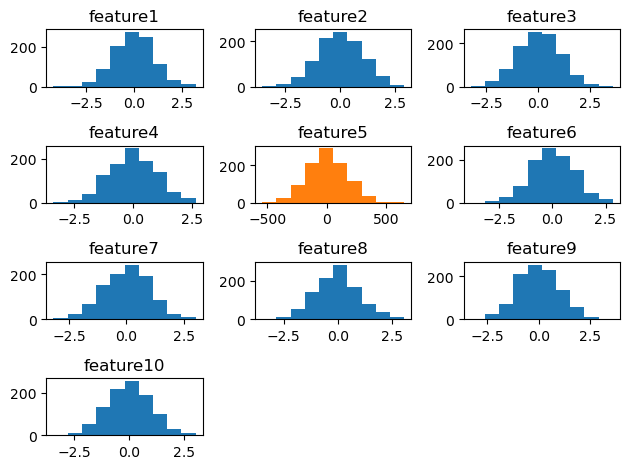

In [7]:
%matplotlib inline
# feature names 1-10
features = ['feature'+str(i) for i in range(1,11)]
for j in range(X.shape[1]):    
    plt.subplot(4,3,j+1)
    plt.hist(X[:,j])
    plt.title(features[j])

plt.subplot(4,3,5)
print(y)
plt.hist(y)
plt.tight_layout()  # ensure sensible layout of subplots

In [39]:
def grad_check(f,xy0,delta=1e-6,tolerance=1e-7):
    f0,g0 = f(xy0)
    p = len(xy0)
    finite_diff = np.zeros(p)
    gradient_correct = True
    for i in range(p):
        xy1 = np.copy(xy0)
        xy2 = np.copy(xy0)
        xy1[i] = xy1[i] - 0.5*delta
        xy2[i] = xy2[i] + 0.5*delta
        f1,_ = f(xy1)
        f2,_ = f(xy2)
        finite_diff = (f2 - f1)/(delta)
        if (abs(finite_diff - g0[i])>tolerance):
            print("Broken partial",i," Finite Diff: ",finite_diff," Partial: ",g0[i])
            gradient_correct = False
    return gradient_correct
def f_broken(xy):
    x = xy[0]
    y = xy[1]
    f = -(x-1.0)**2.0 - (y-2.0)**2.0 + 0.5*x*y
    dfdx = -2.0*(x-1.0) + 0.5*y
    dfdy = -2.0*(y-2.0) - 0.5*x
    grad = [dfdx,dfdy]
    return f,grad
def f_correct(xy):
    x = xy[0]
    y = xy[1]
    f = -(x-1.0)**2.0 - (y-2.0)**2.0 + 0.5*x*y
    dfdx = -2.0*(x-1.0) + 0.5*y
    dfdy = -2.0*(y-2.0) + 0.5*x
    grad = [dfdx,dfdy]
    return f,grad
xy = np.asarray([1.0,1.0]) 
print("f_broken has correct gradient:", grad_check(f_broken,[1.0,1.0])) 
print("f_correct has correct gradient:", grad_check(f_correct,[1.0,1.0]))


Broken partial 1  Finite Diff:  2.500000000349445  Partial:  1.5
f_broken has correct gradient: False
f_correct has correct gradient: True


In [60]:
# import StandardScaler
from sklearn.preprocessing import StandardScaler 

X,Y = make_regression(n_samples=100, n_features=10, noise=0.1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
Y = scaler.fit_transform(Y.reshape(-1,1)).flatten() # SOS: reshape(-1,1) is needed to make Y a column vector

def linear_regression_log_likelihood(Y,X,betas,sigma2=1.0):
    ll = 0
    beta0 = betas[0]
    beta = betas[1:]
    dlldbeta0 = 0
    dlldbeta = np.zeros(len(beta))    
    for (x,y) in zip(X,Y):
        ll = ll -0.5*np.log(2*np.pi*sigma2)        
        res = y - beta0 - np.sum(x*beta)
        ll = ll - 1.0/(2.0*sigma2)*(res**2.0)
        dlldbeta0 = dlldbeta0 - 1.0/sigma2*res*(-1)
        dlldbeta = dlldbeta - 1.0/sigma2*(res*(-x))
    grad = np.zeros(len(beta)+1)
    grad[0] = dlldbeta0
    grad[1:] = dlldbeta
    return ll, grad

init_beta = [0.1]*11
f = lambda betas: linear_regression_log_likelihood(Y,X,betas)
grad_check(f,init_beta)

True

In [79]:
def gradient_ascent(f,theta,init_step,iterations):  
    f_val,grad = f(theta)                       # compute function value and gradient 
    f_vals = [f_val]                            # keep track of function values
    for it in range(iterations):                # iterate for a fixed number of iterations
        done = False                            # initial condition for done
        line_search_it = 0                      # how many times we tried to shrink the step
        step = init_step                        # reset step size to the initial size
        while not done and line_search_it<1000:  # are we done yet?
            new_theta = theta + step*grad       # take a step along the gradient
            new_f_val,new_grad = f(new_theta)   # evaluate function value and gradient
            if new_f_val<f_val:                 # did we go too far?
                step = step*0.95                # if so, shrink the step-size
                line_search_it += 1             # how many times did we shrank the step
            else:
                done = True                     # better than the last theta, so we move on
        
        if not done:                            # did not find right step size
            print("Line Search failed.")
        else:
            f_val = new_f_val                   # ah, we are ok, accept the new theta
            theta = new_theta
            grad = new_grad
            f_vals.append(f_val)
        plt.plot(f_vals)
    plt.xlabel('Iterations')
    plt.ylabel('Function value')
    return f_val, theta     

Beta beta0 = 7.825555106187107e-14
Beta beta1 = 0.09225504196795126
Beta beta2 = 0.018935942422776998
Beta beta3 = 0.40446103007169504
Beta beta4 = 0.5818496311171428
Beta beta5 = 0.17750650771570592
Beta beta6 = 0.500032930591378
Beta beta7 = 0.03708268209411346
Beta beta8 = 0.38208660273455886
Beta beta9 = 0.23127360894907628
Beta beta10 = 0.18459312060829774


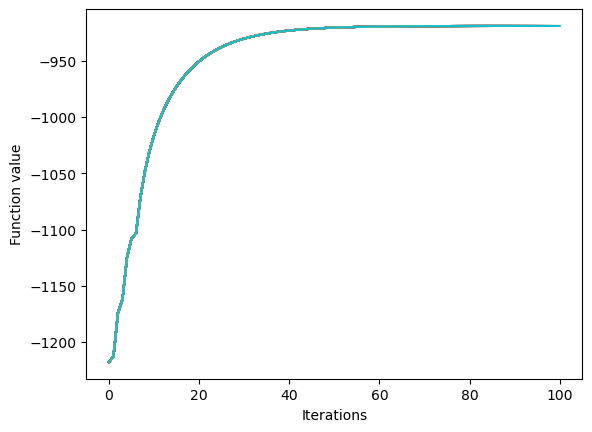

In [83]:
# import StandardScaler
from sklearn.preprocessing import StandardScaler 

X,Y = make_regression(n_samples=1000, n_features=10, noise=0.1)
scaler = StandardScaler()
X = scaler.fit_transform(X)
Y = scaler.fit_transform(Y.reshape(-1,1)).flatten() # SOS: reshape(-1,1) is needed to make Y a column vector

init_beta = [0.1]*11
init_step = 0.1
iterations = 1000
f = lambda betas: linear_regression_log_likelihood(Y,X,betas)
[f_best,betas_mle] = gradient_ascent(f,init_beta,0.01,100)
names = ['beta0'] + ['beta'+str(i) for i in range(1,11)]
for (name,beta) in zip(names,betas_mle):
    print('Beta',name,'=',beta)